<a href="https://colab.research.google.com/github/CarlosVaquero/BudgetBuddy/blob/main/nibud_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/CarlosVaquero/BudgetBuddy/


In [26]:
! pip install --upgrade --quiet  html2text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
!pip install langchain_community
!pip install langchain-google-genai
!pip install langchain-chroma
!pip install faiss-cpu
!pip install -U langgraph
! pip install lxml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.2 MB/s eta 0:0

In [8]:
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer

from langchain.tools import BaseTool
from pydantic import Field

import requests


import os
import getpass
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.vectorstores import FAISS
from langchain.tools.retriever import create_retriever_tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display, Markdown
import textwrap
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage, trim_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver

from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer

from langchain.tools import BaseTool
from pydantic import Field

import requests
from bs4 import BeautifulSoup
import re
import time


import requests


In [6]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ['GOOGLE_API_KEY'] = getpass.getpass('Gemini API Key:')

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")



Gemini API Key:··········
Enter your Tavily API key: ··········


In [7]:

# Create LLM model
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_retries=2
)


In [100]:
class WebsiteContentTool(BaseTool):
    name: str = Field(default="website_content_tool", description="The name of the tool") # Define name as a Pydantic Field with type annotation
    description: str = Field(default="Useful for retrieving the content of a given website URL. Input should be a valid URL.", description="The description of the tool")  # Define description as a Pydantic Field with type annotation

    def _run(self, urls):
        try:
            loader = AsyncHtmlLoader(urls)
            docs = loader.load()
            html2text = Html2TextTransformer()
            docs_transformed = html2text.transform_documents(docs)

            return docs_transformed

        except requests.exceptions.RequestException as e:
            return f"Error fetching URL: {e}"
        except Exception as e:
            return f"An unexpected error occurred: {e}"

    async def _arun(self, url: str) -> str:
        """Use the tool asynchronously."""
        raise NotImplementedError("WebsiteContentTool does not support async")



def remove_duplicates(l): # remove duplicates and unURL string
    for item in l:
        match = re.search(r"(?P<url>https?://[^\s]+)", item)
        if match is not None:
            links.append((match.group("url")))

def get_all_urls_in_website(url):
    # Set up headers to mimic a browser request
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Safari/537.36'
    }

    # Make the request with headers
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all links
        links = [a.get('href') for a in soup.find_all('a', href=True)]

        # Print the list of links
        print("Links found:", links)
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")

    #remove duplicates
    links = list(set(links))

    return links

def remove_special_strings(lst):
    return [item for item in lst if not (item.startswith('/') or item.startswith('#'))]

def filter_non_nibud_links(lst):
    return [item for item in lst if item.startswith('https://www.nibud.nl/')]


In [101]:
links = get_all_urls_in_website(url='https://www.nibud.nl/onderwerpen/')

links = filter_non_nibud_links(links)

WCT = WebsiteContentTool()

docs_transformed = WCT._run(links)

Links found: ['#main-content', 'https://www.nibud.nl/', '/pers-nieuws/', 'https://winkel.nibud.nl/', 'https://www.nibud.nl/onderwerpen/', 'https://www.nibud.nl/onderwerpen/rondkomen/', 'https://www.nibud.nl/onderwerpen/sparen/', 'https://www.nibud.nl/onderwerpen/uitgaven/', 'https://www.nibud.nl/onderwerpen/geldproblemen/', 'https://www.nibud.nl/onderwerpen/inkomensondersteuning/', 'https://www.nibud.nl/onderwerpen/kinderen-en-jongeren/', 'https://www.nibud.nl/onderwerpen/wonen/', 'https://www.nibud.nl/onderwerpen/pensioen/', 'https://www.nibud.nl/onderwerpen/scheiden/', 'https://www.nibud.nl/onderwerpen/werken/', 'https://www.nibud.nl/dossiers/', 'https://www.nibud.nl/dossiers/voldoende-inkomen/', 'https://www.nibud.nl/dossiers/financiele-weerbaarheid/', 'https://www.nibud.nl/dossiers/betaalbaar-wonen/', 'https://www.nibud.nl/dossiers/betaalbare-energietransitie/', 'https://www.nibud.nl/samenwerken/', 'https://www.nibud.nl/samenwerken/voorlichting-op-maat/', 'https://www.nibud.nl/same

Fetching pages: 100%|##########| 40/40 [00:20<00:00,  1.91it/s]


In [102]:

# Load the document, split it into chunks, embed each chunk and load it into the vector store.
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
documents = text_splitter.split_documents(docs_transformed)

In [103]:
len(docs_transformed)

40

In [104]:

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
vector_store_path = "BudgetBuddy/vectorstore/faiss_index"
try:
    #db_chroma = Chroma.from_documents(documents, embeddings)
    db_faiss = FAISS.load_local(
        vector_store_path, embeddings, allow_dangerous_deserialization=True
    )
    print("Loaded vector store from file")
except Exception:
    db_faiss = FAISS.from_documents(documents, embeddings)
    db_faiss.save_local(vector_store_path)
    print("Saved vector store to file")


Loaded vector store from file


In [54]:
query = "Kan ik mijn creditcard transacties zien in Kijk Vooruit?"
docs = db_faiss.similarity_search(query)
for i, doc in enumerate(docs):
    print(f"\n\nDocument {i+1}:")
    print(doc.page_content)




Document 1:
Het bijhouden van uitgaven is vaak de eerste stap als je wilt besparen. We
geven vaak ongemerkt meer uit dan we denken. Als je weet waar het geld naartoe
gaat, kun je gaan budgetteren. Dat geeft grip.

Veel bankieren-apps plaatsen je uitgaven al in bepaalde categorieën, zoals
boodschappen, kleding en wonen. Je kunt de uitgaven ook in een kasboek of
schriftje opschrijven. Het Nibud heeft een handig kasboek dat je kunt kopen in
de webwinkel.

  * ###  Kasboek 

Product

Snel en eenvoudig inzicht in de dagelijkse uitgaven.

Vanaf €9.95 (incl. btw)

Bestel in de winkel Opent in een nieuw venster

## **Tips om geld te besparen**

Boodschappen, tussendoortjes of (online) shoppen. Vele kleine uitgaven kunnen
bij elkaar een groot bedrag zijn. Daar kun je misschien op besparen als je er
iets meer bij stilstaat. Heb ik dit echt nodig? Kan dit goedkoper? Met deze
tips wordt het makkelijker om te besparen.

### **Geld besparen op boodschappen**


Document 2:
Direct naar content

  * 

In [55]:

retriever = db_faiss.as_retriever(
    # search_type="mmr",
    search_kwargs={"k": 5},
)

In [56]:

retriever_tool_nibud = create_retriever_tool(
    retriever,
    "retrieve_nibud_information",
    "Search and return information about (banking) NiBud.",
)

In [57]:
search_tool = TavilySearchResults(max_results=2)
search_tool.description

'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.'

In [59]:
tools = [retriever_tool_nibud, search_tool]
tools_names = {t.name: t for t in tools}
model = model.bind_tools(tools)

In [60]:
def wrap_text(text, width=100):
    text_split = text.split("\n")
    wrapped_text = textwrap.fill(text_split[0], width)
    if len(text_split) > 1:
        for line in text_split[1:]:
            wrapped_text += "\n" + textwrap.fill(line, width)
    return wrapped_text

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            print(wrap_text(message.pretty_repr()))

def ask(agent, question, config=None, verbose=False):
    messages = [HumanMessage(content=question)]
    if verbose:
        print_stream(agent.stream({"messages": messages}, config=config, stream_mode= "values"))
    else:
        result = agent.invoke({"messages": messages}, config=config)
        display(Markdown(wrap_text(result['messages'][-1].content)))

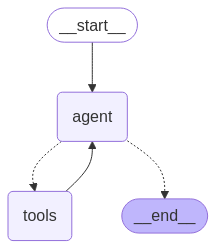

In [66]:
prompt = """
    You are a helpful assistant representing Nibud.
    Your goal is to find a satisfying answer to each question of a customer.
    If necessary, decompose the question into multiple tasks, and try
    to use the tools at your disposal to answer the subtasks before coming
    up with the final answer.
    Don't ask the user for confirmation.
    Just do stuff.
    Try to pitch suggestions from Nibud inside your answers when that would
    be potentially benefitial for the customer. Only do that when that pitch is
    relevant to the question asked by the customer or the answer you came up with.
"""

memory = MemorySaver()
agent = create_react_agent(model, tools, prompt=prompt, checkpointer=memory)
display(Image(agent.get_graph().draw_mermaid_png()))

In [67]:
config = {"configurable": {"thread_id": "2"}}
ask(agent, "how can I save money on shopping", config=config)

Here are some tips on how to save money on shopping, based on information from Nibud:

*   **Plan your meals:** Create a weekly meal plan and shop for groceries once a week to avoid
impulse purchases.
*   **Check flyers and compare prices:** Look at supermarket flyers for deals and compare prices per
kilo or liter to see which brands are cheaper.
*   **Buy store brands:** Opt for cheaper store brands for products where the brand doesn't matter
to you.
*   **Avoid shopping when hungry:** Eat before you go grocery shopping to avoid buying unnecessary
snacks.
*   **Consider second-hand:** Explore second-hand options or cheaper brands instead of always buying
new and expensive items.
*   **Shop in the off-season:** Buy items like holiday decorations after the holidays or camping
gear after the summer to get them at a discount.
*   **Track your spending:** Keep track of your expenses to see where your money is going and
identify areas where you can cut back. Nibud offers a kasboek (cash book) to help with this.

By being more mindful of your spending habits and making small changes, you can save a significant
amount of money on shopping.

In [70]:
config = {"configurable": {"thread_id": "2"}}
ask(agent, "What is the advantage of making a weekplanning in shopping according to Nibud? Answer in dutch", config=config)

Volgens het Nibud heeft het maken van een weekplanning voor het winkelen de volgende voordelen:

*   Het bespaart tijd en geld.
*   Het vermindert de verleiding om extra spullen te kopen.
*   Het maakt het mogelijk om maaltijden te plannen op basis van aanbiedingen.

In [ ]:
from langchain_community.document_transformers import BeautifulSoupTransformer

bs4_transformer = BeautifulSoupTransformer()
docs_transformed = bs4_transformer.transform_documents(docs)